<div class="alert alert-block alert-info">
<a class="anchor" id="first-bullet">     
    

# 1. Importing Necessary Library

</a>
    
</div>

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score

In [3]:
# df_sample = pd.read_csv("sample_submission.csv")
# df_sample

<div class="alert alert-block alert-info">
<a class="anchor" id="first-bullet">     
    

# 2. Exploring DataSet

</a>
    
</div>

In [4]:
df_train = pd.read_csv("train.csv")
df_train.head()

,Access_ID,Date,AccountMng_Pages,AccountMng_Duration,FAQ_Pages,FAQ_Duration,Product_Pages,Product_Duration,GoogleAnalytics_BounceRate,GoogleAnalytics_ExitRate,GoogleAnalytics_PageValue,OS,Browser,Country,Type_of_Traffic,Type_of_Visitor,Buy
0,102863333,21-Mar-20,0,0.0,0,0.0,3,64.0000,0.0000,0.0667,0.0000,MacOSX,2,Portugal,1,Returner,0
1,103117814,20-May-20,0,0.0,0,0.0,23,684.5000,0.0217,0.0449,0.0000,Windows,2,France,6,Returner,0
2,103201891,4-Dec-20,0,0.0,0,0.0,8,95.0000,0.0250,0.0583,0.0000,Windows,4,Italy,1,Returner,0
3,103226087,22-Dec-20,0,0.0,0,0.0,9,608.7500,0.0000,0.0250,42.4225,Windows,2,United Kingdom,2,Returner,1
4,103234445,24-Nov-20,0,0.0,2,386.0,36,1609.9397,0.0000,0.0093,12.5033,Windows,2,Spain,3,Returner,1


In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9999 entries, 0 to 9998
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Access_ID                   9999 non-null   int64  
 1   Date                        9999 non-null   object 
 2   AccountMng_Pages            9999 non-null   int64  
 3   AccountMng_Duration         9999 non-null   float64
 4   FAQ_Pages                   9999 non-null   int64  
 5   FAQ_Duration                9999 non-null   float64
 6   Product_Pages               9999 non-null   int64  
 7   Product_Duration            9999 non-null   float64
 8   GoogleAnalytics_BounceRate  9999 non-null   float64
 9   GoogleAnalytics_ExitRate    9999 non-null   float64
 10  GoogleAnalytics_PageValue   9999 non-null   float64
 11  OS                          9999 non-null   object 
 12  Browser                     9999 non-null   int64  
 13  Country                     9999 

In [6]:
df_train.Buy.value_counts()

0    8447
1    1552
Name: Buy, dtype: int64

### <font color='#E8800A'>Features  

- Access_ID - Unique identification of the user access to the website 
- Date - Website visit date
- AccountMng_Pages - Number of pages visited by the user about account management
- AccountMng_Duration - Total amount of time (seconds) spent by the user on account management related pages
- FAQ_Pages - Number of pages visited by the user about frequently asked questions, shipping information and company related pages
- FAQ_Duration - Total amount of time (seconds) spent by the user on FAQ pages
- Product_Pages - Number of pages visited by the user about products and services offered by the company
- Product_Duration - Total amount in time (seconds) spent by the user on products and services related pages
- GoogleAnalytics_BounceRate - Average bounce rate value of the pages visited by the user, provided by google analytics
- GoogleAnalytics_ExitRate - Average exit rate value of the pages visited by the user, provided by google analytics
- GoogleAnalytics_PageValue - Average page value of the pages visited by the user, provided by google analytics
- OS - Operating System of the user
- Browser - Browser used to access the webpage
- Country - The country of the user
- Type_of_Traffic - Traffic Source by which the user has accessed the website (e.g., email, banner, direct)
- Type_of_Visitor - User type as "New access", "Returner" or "Other"
- Buy - Class label indicating if the user finalized their actions in the website with a transaction

In [7]:
df_train_original = df_train.copy()

In [8]:
#droping product_Duration column
#df_train = df_train.drop(columns = ["Product_Duration"])

In [12]:
# No data from January and April
print(len(df_train[df_train.Date.str.contains("Jan")]), 
      len(df_train[df_train.Date.str.contains("Apr")]))

0 0


In [76]:
#df_train.info()

In [77]:
# Note: bounce rate is always less then exit rate, all bounce are exits but vice verca is not true.
# if we are considering the bounce rate of particular webpage(let's say A), then the total number of session for that calculation has to be included only those sessions which has been started with A. 
# Exit rate of zero is impossible unless you visit the website

In [78]:
df_train.Buy.value_counts().sum().astype(int)

9999

In [79]:
# Binary Target Variable
df_train.Buy.value_counts()

0    8447
1    1552
Name: Buy, dtype: int64

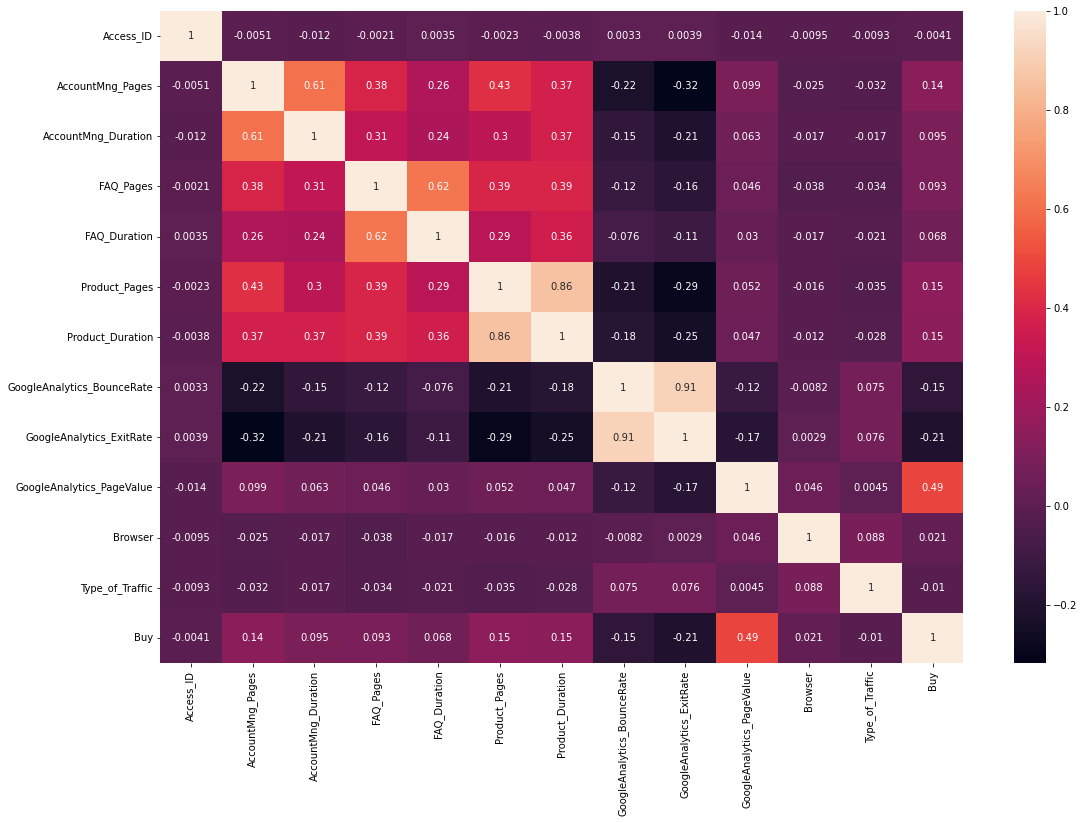

In [80]:
# building a correlaton heatmap for visual representation of correlation between each numerical variables
# Here we are using pearson correlation coefficient
plt.figure(figsize = (18,12))
sns.heatmap(df_train.corr(), annot = True)
plt.show()

In [81]:
df_train.Date.value_counts()

25-May-20    120
5-May-20     111
7-May-20     110
14-May-20    110
8-May-20     109
            ... 
28-Jun-20      3
16-Feb-20      2
29-Feb-20      2
17-Feb-20      2
15-Feb-20      2
Name: Date, Length: 305, dtype: int64

In [82]:
# converting column "Date" from object to Datetime
df_train.Date = df_train.Date.apply(pd.to_datetime)

In [83]:
df_train.head()

,Access_ID,Date,AccountMng_Pages,AccountMng_Duration,FAQ_Pages,FAQ_Duration,Product_Pages,Product_Duration,GoogleAnalytics_BounceRate,GoogleAnalytics_ExitRate,GoogleAnalytics_PageValue,OS,Browser,Country,Type_of_Traffic,Type_of_Visitor,Buy
0,102863333,2020-03-21,0,0.0,0,0.0,3,64.0000,0.0000,0.0667,0.0000,MacOSX,2,Portugal,1,Returner,0
1,103117814,2020-05-20,0,0.0,0,0.0,23,684.5000,0.0217,0.0449,0.0000,Windows,2,France,6,Returner,0
2,103201891,2020-12-04,0,0.0,0,0.0,8,95.0000,0.0250,0.0583,0.0000,Windows,4,Italy,1,Returner,0
3,103226087,2020-12-22,0,0.0,0,0.0,9,608.7500,0.0000,0.0250,42.4225,Windows,2,United Kingdom,2,Returner,1
4,103234445,2020-11-24,0,0.0,2,386.0,36,1609.9397,0.0000,0.0093,12.5033,Windows,2,Spain,3,Returner,1


In [84]:
#Splitting column Date into Month, Year, and Day
df_train["Month"] = pd.DatetimeIndex(df_train["Date"]).month
df_train["Year"] = pd.DatetimeIndex(df_train["Date"]).year
df_train["Day"] = pd.DatetimeIndex(df_train["Date"]).day

In [85]:
# dropping the original column Date from df_train
df_train = df_train.drop(columns = ["Date"])

In [86]:
# since the dataset has same year for every observations, so it is dropped too.
df_train = df_train.drop(columns = ["Year"])

In [87]:
# droping Access_ID 
df_train = df_train.drop(columns = ["Access_ID"])

In [88]:
df_train

,AccountMng_Pages,AccountMng_Duration,FAQ_Pages,FAQ_Duration,Product_Pages,Product_Duration,GoogleAnalytics_BounceRate,GoogleAnalytics_ExitRate,GoogleAnalytics_PageValue,OS,Browser,Country,Type_of_Traffic,Type_of_Visitor,Buy,Month,Day
0,0,0.0,0,0.0,3,64.0000,0.0000,0.0667,0.0000,MacOSX,2,Portugal,1,Returner,0,3,21
1,0,0.0,0,0.0,23,684.5000,0.0217,0.0449,0.0000,Windows,2,France,6,Returner,0,5,20
2,0,0.0,0,0.0,8,95.0000,0.0250,0.0583,0.0000,Windows,4,Italy,1,Returner,0,12,4
3,0,0.0,0,0.0,9,608.7500,0.0000,0.0250,42.4225,Windows,2,United Kingdom,2,Returner,1,12,22
4,0,0.0,2,386.0,36,1609.9397,0.0000,0.0093,12.5033,Windows,2,Spain,3,Returner,1,11,24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9994,3,159.0,2,55.5,23,1100.1250,0.0000,0.0111,0.0000,MacOSX,2,Brazil,14,Returner,0,5,8
9995,6,175.1,0,0.0,3,27.6000,0.0000,0.0111,0.0000,Windows,10,Spain,5,New_Access,0,7,17
9996,0,0.0,0,0.0,27,644.0000,0.0077,0.0519,0.0000,MacOSX,2,France,3,Returner,0,3,23
9997,0,0.0,0,0.0,53,715.5000,0.0226,0.0363,0.0000,Windows,2,Italy,3,Returner,0,5,16


##### First step on dimensionality reduction by merging some relevent features

In [89]:
# combining features with duration and pages by creating a single feature called duration per page
df_train["Acc_Mng_D_perpage"] = df_train["AccountMng_Duration"] / df_train["AccountMng_Pages"]

# Small note
#zero value for Acc_Mng_D_perpage indicates two distinct reason
# 1. The user accessed to the Account-Management page but did not stay there
# 2. The user did not accessed to the page and obviously it has nothing to do with AccoutMng_Duration
# anyway, value zero for AccountMng_Pages always has its corresponding value zero for AccountMng_Duration

In [90]:
# Similarly we can obtain relevency from four more columns((FAQ_Pages abd FAQ_Duration), 
# and (Product_Pages and product_Duration)))
df_train["FAQ_Duration_perpage"] = df_train["FAQ_Duration"] / df_train["FAQ_Pages"]
df_train["Product_Duration_perpage"] = df_train["Product_Duration"] / df_train["Product_Pages"]
df_train = df_train.drop(columns = ["AccountMng_Pages","AccountMng_Duration","FAQ_Pages","FAQ_Duration","Product_Pages","Product_Duration"])
df_train = df_train.replace(np.nan, 0)

In [91]:
df_train

,GoogleAnalytics_BounceRate,GoogleAnalytics_ExitRate,GoogleAnalytics_PageValue,OS,Browser,Country,Type_of_Traffic,Type_of_Visitor,Buy,Month,Day,Acc_Mng_D_perpage,FAQ_Duration_perpage,Product_Duration_perpage
0,0.0000,0.0667,0.0000,MacOSX,2,Portugal,1,Returner,0,3,21,0.000000,0.00,21.333333
1,0.0217,0.0449,0.0000,Windows,2,France,6,Returner,0,5,20,0.000000,0.00,29.760870
2,0.0250,0.0583,0.0000,Windows,4,Italy,1,Returner,0,12,4,0.000000,0.00,11.875000
3,0.0000,0.0250,42.4225,Windows,2,United Kingdom,2,Returner,1,12,22,0.000000,0.00,67.638889
4,0.0000,0.0093,12.5033,Windows,2,Spain,3,Returner,1,11,24,0.000000,193.00,44.720547
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9994,0.0000,0.0111,0.0000,MacOSX,2,Brazil,14,Returner,0,5,8,53.000000,27.75,47.831522
9995,0.0000,0.0111,0.0000,Windows,10,Spain,5,New_Access,0,7,17,29.183333,0.00,9.200000
9996,0.0077,0.0519,0.0000,MacOSX,2,France,3,Returner,0,3,23,0.000000,0.00,23.851852
9997,0.0226,0.0363,0.0000,Windows,2,Italy,3,Returner,0,5,16,0.000000,0.00,13.500000


In [92]:
#Define metric and non-metric features
non_metric_features = ['OS',"Country","Type_of_Visitor"]
metric_features = df_train.columns.drop(non_metric_features).to_list()
metric_features

['GoogleAnalytics_BounceRate',
 'GoogleAnalytics_ExitRate',
 'GoogleAnalytics_PageValue',
 'Browser',
 'Type_of_Traffic',
 'Buy',
 'Month',
 'Day',
 'Acc_Mng_D_perpage',
 'FAQ_Duration_perpage',
 'Product_Duration_perpage']

### Outlier Detection and Removal (Metric Features)

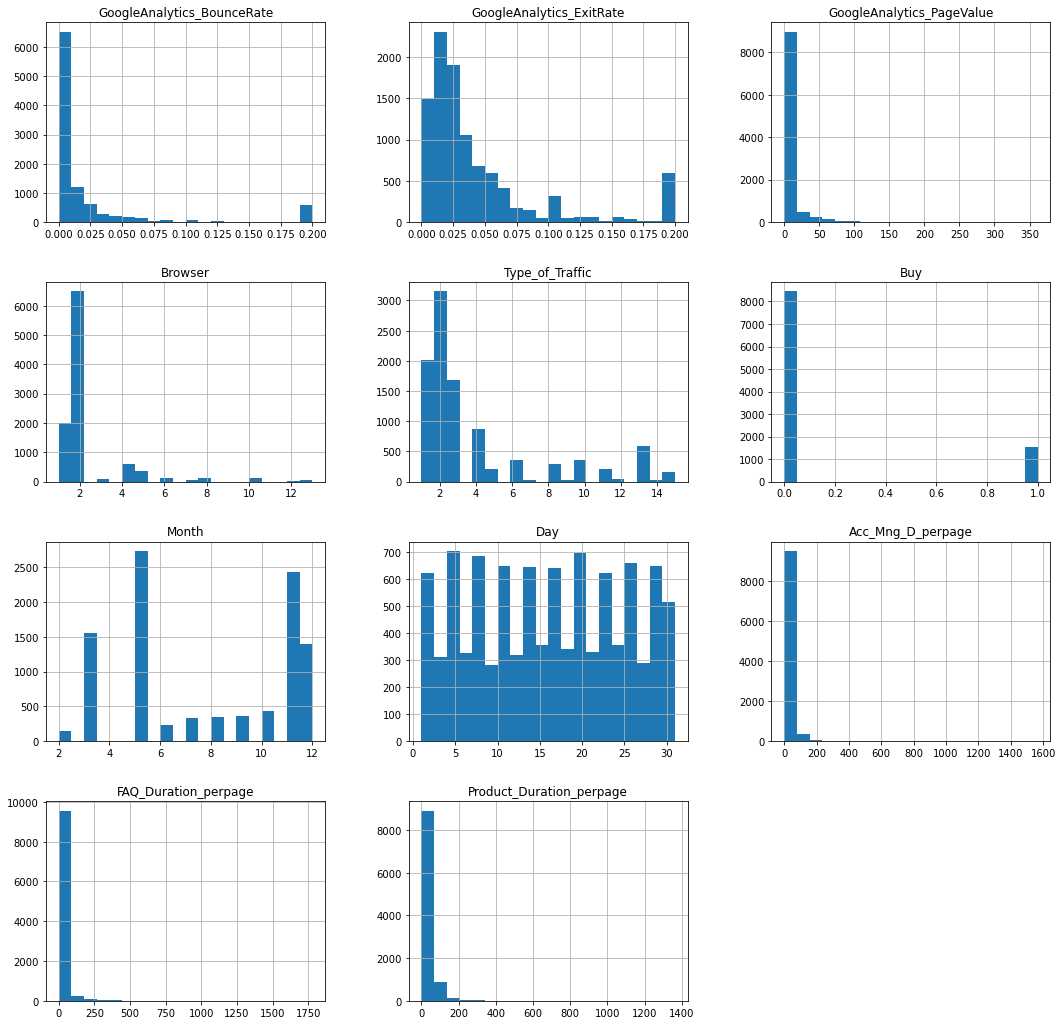

In [95]:
df_train.hist(bins = 20,figsize = (18,18))
plt.show()

In [96]:
# data = df_train["Acc_Mng_D_perpage"].to_list()    

# #calculate mean
# mean = np.mean(data) 
# # calculate standard deviation
# sd = np.std(data)
# # determine a threhold
# threshold = 2
# # create empty list to store outliers
# outliers = []
# # detect outlier
# for i in data: 
#     z = (i-mean)/sd # calculate z-score
#     if abs(z) > threshold:  # identify outliers
#         outliers.append(i) # add to the empty list
# # print outliers    
# #print("The detected outliers are: ", outliers)
# len(outliers)

<div class="alert alert-block alert-info">
<a class="anchor" id="first-bullet">     
    

# 3. Encoding Categorical Features
     
</a>
    
</div>

[<font color='#E8800A'>1 - Label Encoding</font>](#first-bullet) <br>
[<font color='#E8800A'>2 - Ordinal Encoding </font>](#second-bullet) <br>
[<font color='#E8800A'>3 - One-hot Encoding</font>](#third-bullet) <br>

In [97]:
# Let's try label encoding technique to replace categorical variables of type object into numerical type.

In [98]:
df_train_original.OS.value_counts()

Windows      5361
Android      2104
MacOSX       2065
iOS           378
Ubuntu         68
Chrome OS      15
Other           5
Fedora          3
Name: OS, dtype: int64

In [99]:
# we have to change all of the object type into categorical type, let us decide the hierarcy based on the value counts.
Label_encoder = LabelEncoder()
df_train["OS"] = Label_encoder.fit_transform(df_train[["OS"]])
df_train["Country"] = Label_encoder.fit_transform(df_train[["Country"]])
df_train["Type_of_Visitor"] = Label_encoder.fit_transform(df_train[["Type_of_Visitor"]])

C:\Users\luite\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [100]:
df_train.OS.value_counts()

6    5361
0    2104
3    2065
7     378
5      68
1      15
4       5
2       3
Name: OS, dtype: int64

In [101]:
df_train.describe()

,GoogleAnalytics_BounceRate,GoogleAnalytics_ExitRate,GoogleAnalytics_PageValue,OS,Browser,Country,Type_of_Traffic,Type_of_Visitor,Buy,Month,Day,Acc_Mng_D_perpage,FAQ_Duration_perpage,Product_Duration_perpage
count,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000
mean,0.022305,0.043181,5.963120,4.139214,2.352535,4.239524,3.957496,1.714371,0.155216,7.645865,15.790879,19.974424,15.012781,37.612583
std,0.048776,0.048845,18.753626,2.461876,1.715698,2.139825,3.675159,0.694493,0.362128,3.398354,8.783838,45.427421,66.046988,43.579357
min,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,2.000000,1.000000,0.000000,0.000000,0.000000
25%,0.000000,0.014300,0.000000,3.000000,2.000000,3.000000,2.000000,2.000000,0.000000,5.000000,8.000000,0.000000,0.000000,17.702041
50%,0.003200,0.025100,0.000000,6.000000,2.000000,5.000000,2.000000,2.000000,0.000000,7.000000,16.000000,5.000000,0.000000,28.917288
75%,0.016800,0.050000,0.000000,6.000000,2.000000,6.000000,4.000000,2.000000,0.000000,11.000000,23.000000,24.136108,0.000000,45.235973
max,0.200000,0.200000,361.763700,7.000000,13.000000,8.000000,15.000000,2.000000,1.000000,12.000000,31.000000,1566.600000,1778.000000,1364.000000


## Data Standarization step

### f-1 score on validation set with standarized features ( for logistic regression)

In [102]:
X = df_train.drop(columns = ["Buy"])
Y = df_train.Buy

# columns = X.columns
# scaler = StandardScaler()
# X_std = scaler.fit_transform(X)
# X_std = pd.DataFrame(X_std, columns = columns)

In [103]:
x_train, x_val, y_train, y_val = train_test_split(X,Y,
                                                    test_size = 0.25,
                                                   random_state = 42)


In [104]:
lr_std = LogisticRegression()

In [105]:
lr_std.fit(x_train, y_train)

C:\Users\luite\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression()

In [106]:
y_pred = lr_std.predict(x_val)

In [107]:
f1_score(y_val, y_pred)

0.5230263157894738

### f-1 score on validation set with normalized features (for logistic regression)

In [108]:
from sklearn.preprocessing import MinMaxScaler

In [109]:
norm = MinMaxScaler()

In [110]:
#X_norm = norm.fit_transform(X)
#X_norm = pd.DataFrame(X_norm, columns = columns)

In [111]:
#x1_train, x1_val, y1_train, y1_val = train_test_split(X_norm,
#                                                         Y, test_size = 0.25,
#                                                         random_state = 42)

In [112]:
#lr_norm = LogisticRegression()

In [113]:
#lr_norm.fit(x1_train, y1_train)

In [114]:
#y_pred_ = lr_norm.predict(x1_val)

In [115]:
#f1_score(y1_val, y_pred_)

## Decision Tree

In [157]:
X_d = df_train.drop(columns = ["Buy"])
Y_d = df_train.Buy

columns = X_d.columns
scaler = StandardScaler()
X_stdn = scaler.fit_transform(X_d)
X_stdn = pd.DataFrame(X_stdn, columns = columns)

In [158]:
x_train_d, x_val_d, y_train_d, y_val_d = train_test_split(X,Y,
                                                    test_size = 0.25,
                                                   random_state = 42)


In [171]:
tree_ = DecisionTreeClassifier(criterion = 'entropy', max_depth = 6)

In [172]:
tree_.fit(x_train_d, y_train_d)

DecisionTreeClassifier(criterion='entropy', max_depth=6)

In [173]:
y_pred_d = tree_.predict(x_val_d)
y_pred_d

array([0, 0, 0, ..., 1, 0, 0], dtype=int64)

In [174]:
f1_score(y_val_d, y_pred_d )

0.6401062416998672

In [175]:
from sklearn.tree import export_graphviz
import graphviz
import pydotplus

def plot_tree(model):
    dot_data = export_graphviz(model,
                               feature_names=x_train.columns,  
                               class_names=[" not buying", "buying"],
                               filled=True)
    pydot_graph = pydotplus.graph_from_dot_data(dot_data)
    pydot_graph.set_size('"20,20"')
    return graphviz.Source(pydot_graph.to_string())

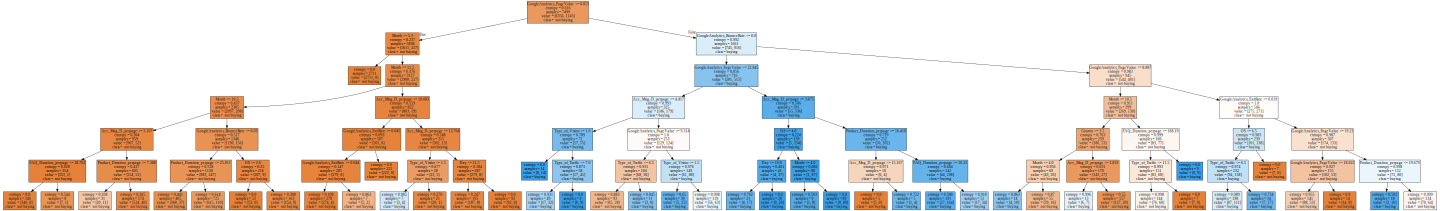

In [176]:
plot_tree(tree_.fit(x_train, y_train))

In [124]:
#we will use below commented part for test purpose later on for kaggle submission

In [125]:
X = df_train.drop(["Buy"], axis = 1)
X

,GoogleAnalytics_BounceRate,GoogleAnalytics_ExitRate,GoogleAnalytics_PageValue,OS,Browser,Country,Type_of_Traffic,Type_of_Visitor,Month,Day,Acc_Mng_D_perpage,FAQ_Duration_perpage,Product_Duration_perpage
0,0.0000,0.0667,0.0000,3,2,5,1,2,3,21,0.000000,0.00,21.333333
1,0.0217,0.0449,0.0000,6,2,1,6,2,5,20,0.000000,0.00,29.760870
2,0.0250,0.0583,0.0000,6,4,3,1,2,12,4,0.000000,0.00,11.875000
3,0.0000,0.0250,42.4225,6,2,8,2,2,12,22,0.000000,0.00,67.638889
4,0.0000,0.0093,12.5033,6,2,6,3,2,11,24,0.000000,193.00,44.720547
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9994,0.0000,0.0111,0.0000,3,2,0,14,2,5,8,53.000000,27.75,47.831522
9995,0.0000,0.0111,0.0000,6,10,6,5,0,7,17,29.183333,0.00,9.200000
9996,0.0077,0.0519,0.0000,3,2,1,3,2,3,23,0.000000,0.00,23.851852
9997,0.0226,0.0363,0.0000,6,2,3,3,2,5,16,0.000000,0.00,13.500000


In [126]:
Y = df_train["Buy"]

In [127]:
df_test = pd.read_csv("test.csv")
df_test

,Access_ID,Date,AccountMng_Pages,AccountMng_Duration,FAQ_Pages,FAQ_Duration,Product_Pages,Product_Duration,GoogleAnalytics_BounceRate,GoogleAnalytics_ExitRate,GoogleAnalytics_PageValue,OS,Browser,Country,Type_of_Traffic,Type_of_Visitor
0,798519314,24-Aug-20,0,0.00,0,0.000,86,5332.5478,0.0139,0.0654,0.0000,Windows,2,Brazil,1,Returner
1,798663101,25-May-20,2,37.50,0,0.000,55,1420.4725,0.0012,0.0058,0.0000,Android,1,Spain,4,Returner
2,798663221,2-Nov-20,0,0.00,0,0.000,36,788.5000,0.0000,0.0250,0.0000,Windows,6,Spain,3,Returner
3,798760918,14-May-20,0,0.00,0,0.000,2,689.0000,0.0000,0.1000,0.0000,Windows,2,Spain,2,New_Access
4,798856982,5-Nov-20,12,225.25,1,0.000,129,3367.0413,0.0014,0.0185,1.0353,Windows,4,Portugal,10,Returner
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2295,962042726,27-Nov-20,10,720.50,2,88.725,220,10580.3448,0.0048,0.0221,0.0000,Windows,2,Portugal,1,Returner
2296,962063064,20-Mar-20,0,0.00,0,0.000,3,55.0000,0.0667,0.1000,0.0000,MacOSX,2,Spain,3,Returner
2297,962147749,22-Nov-20,2,45.50,0,0.000,22,535.0000,0.0000,0.0250,9.6503,Windows,2,Spain,11,Returner
2298,962182167,19-Nov-20,8,166.70,0,0.000,9,171.7000,0.0167,0.0500,0.0000,Windows,2,Portugal,3,Returner


In [128]:
# Also let's do some feature engineering for test dataframe before fiting it into the model.
df_test["Month"] = pd.DatetimeIndex(df_test["Date"]).month
df_test["Year"] = pd.DatetimeIndex(df_test["Date"]).year
df_test["Day"] = pd.DatetimeIndex(df_test["Date"]).day

In [129]:
df_test = df_test.drop(columns = ["Date","Year","Access_ID"])

In [131]:
df_test["OS"] = Label_encoder.fit_transform(df_test[["OS"]])
df_test["Country"] = Label_encoder.fit_transform(df_test[["Country"]])
df_test["Type_of_Visitor"] = Label_encoder.fit_transform(df_test[["Type_of_Visitor"]])

C:\Users\luite\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [132]:
df_test

,AccountMng_Pages,AccountMng_Duration,FAQ_Pages,FAQ_Duration,Product_Pages,Product_Duration,GoogleAnalytics_BounceRate,GoogleAnalytics_ExitRate,GoogleAnalytics_PageValue,OS,Browser,Country,Type_of_Traffic,Type_of_Visitor,Month,Day
0,0,0.00,0,0.000,86,5332.5478,0.0139,0.0654,0.0000,6,2,0,1,2,8,24
1,2,37.50,0,0.000,55,1420.4725,0.0012,0.0058,0.0000,0,1,6,4,2,5,25
2,0,0.00,0,0.000,36,788.5000,0.0000,0.0250,0.0000,6,6,6,3,2,11,2
3,0,0.00,0,0.000,2,689.0000,0.0000,0.1000,0.0000,6,2,6,2,0,5,14
4,12,225.25,1,0.000,129,3367.0413,0.0014,0.0185,1.0353,6,4,5,10,2,11,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2295,10,720.50,2,88.725,220,10580.3448,0.0048,0.0221,0.0000,6,2,5,1,2,11,27
2296,0,0.00,0,0.000,3,55.0000,0.0667,0.1000,0.0000,3,2,6,3,2,3,20
2297,2,45.50,0,0.000,22,535.0000,0.0000,0.0250,9.6503,6,2,6,11,2,11,22
2298,8,166.70,0,0.000,9,171.7000,0.0167,0.0500,0.0000,6,2,5,3,2,11,19


In [133]:
# Creating logistic regression instance
log_model = LogisticRegression(random_state = 42)

In [ ]:
# log_model.fit(X_train,Y_train)

In [ ]:
# y_pred = log_model.predict(df_test)

In [134]:
y_pred

array([0, 0, 0, ..., 1, 0, 0], dtype=int64)

In [145]:
print(y_pred.tolist().count(0), y_pred.tolist().count(1))



2301 199


In [177]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators = 1000)
abc = clf.fit(x_train_d, y_train_d)
y_pred = clf.predict(x_val_d)
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score


In [178]:
f1_score(y_val_d, y_pred)

0.6327372764786796

In [148]:
print('F1 Score:' ,f1_score(y_val_d, y_pred))
print('Mean Accuracy:' ,abc.score(x_val, y_val))

F1 Score: 0.6390041493775933
Mean Accuracy: 0.8956
